# 파이토치 MNIST 모델

## modules import

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')

## 전처리 설정
- `transform.Compose`

In [129]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, ), (.5, ))
])

## 데이터 로드 및 데이터 확인

In [130]:
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [131]:
train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=2
)

In [132]:
img, label = next(iter(train_loader))

In [133]:
img.shape, label.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [134]:
def imshow(img):
    img = img / 2 + .5
    np_img = img.numpy()
    
    fig = plt.figure(figsize=(10, 5))

    plt.imshow(np.transpose(np_img, (1, 2, 0)))

    plt.show()

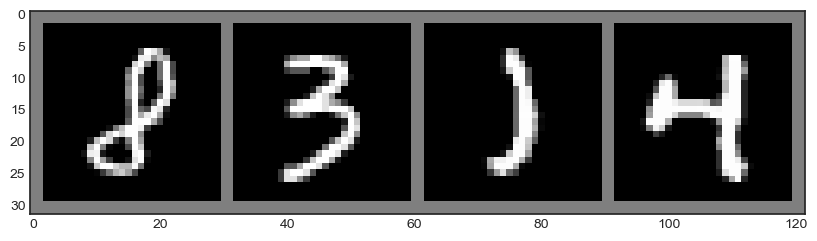

In [135]:
data_iter = iter(train_loader)
imgs, labels = next(data_iter)
imshow(torchvision.utils.make_grid(imgs[:4]))

## 신경망 구성

In [136]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = nn.Conv2d(1, 6, 3)
        self.conv_2 = nn.Conv2d(6, 16, 3)
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv_1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv_2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)

        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        
        for s in size:
            num_features *= s
        
        return num_features

net = Net()

- `.parameters()`

In [137]:
params = list(net.parameters())

print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


임의의 값을 넣어 forward값 확인

In [138]:
input = torch.randn(1, 1, 28, 28)
out = net(input)

out

tensor([[ 0.0452, -0.0184,  0.0690, -0.0040,  0.0032, -0.0554, -0.1163, -0.1512,
          0.0332, -0.0108]], grad_fn=<AddmmBackward0>)

## 손실함수와 옵티마이저

In [139]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=.9)

## 모델 학습

- `optimizer.zero_grad` : 가중치의 그래디언트 초기화

- loss 계산

- `loss.backward()`

- `optmizer.step()` : 업데이트

- 배치수 확인

In [140]:
total_batch = len(train_loader)

total_batch

469

- 설명을 위해 `epochs=2`로 지정

In [141]:
for epoch in range(2):
    running_loss = .0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Iter: {i + 1}, Loss: {running_loss / 2_000}")
            running_loss = .0

Epoch: 1, Iter: 100, Loss: 0.1151489576101303
Epoch: 1, Iter: 200, Loss: 0.11488068091869354
Epoch: 1, Iter: 300, Loss: 0.11468147397041321
Epoch: 1, Iter: 400, Loss: 0.11431407713890075
Epoch: 2, Iter: 100, Loss: 0.11323310613632202
Epoch: 2, Iter: 200, Loss: 0.11201594483852387
Epoch: 2, Iter: 300, Loss: 0.10958821201324463
Epoch: 2, Iter: 400, Loss: 0.10293292689323426


## 모델의 저장 및 로드

- `torch.save`
  - `net.state_dict()`를 저장

- `torch.load`
  - `load_state_dict`로 모델을 로드

In [142]:
PATH = './data/MNIST/mnist_net.pth'
torch.save(net.state_dict(), PATH)

In [143]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [144]:
net.parameters

<bound method Module.parameters of Net(
  (conv_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc_1): Linear(in_features=400, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)>

## 모델 테스트

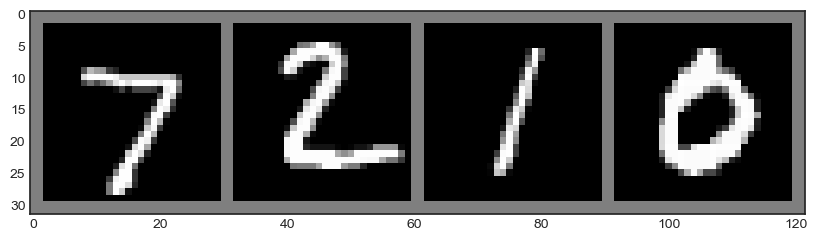

In [145]:
data_iter = iter(test_loader)
imgs, labels = next(data_iter)

imshow(torchvision.utils.make_grid(imgs[:4]))

In [146]:
outputs = net(imgs)

In [147]:
pred_vals, pred_indices = torch.max(outputs, 1)

pred_indices

tensor([7, 8, 1, 0, 0, 1, 7, 9, 0, 7, 0, 0, 9, 0, 1, 0, 4, 7, 3, 4, 7, 6, 4, 6,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 8, 1, 1, 7, 4, 2, 8, 6, 1, 2,
        4, 4, 6, 0, 0, 0, 0, 0, 0, 1, 4, 1, 7, 8, 9, 8, 7, 9, 2, 4, 3, 0, 7, 0,
        0, 8, 1, 7, 3, 7, 1, 7, 9, 6, 2, 7, 4, 4, 7, 3, 6, 1, 3, 6, 1, 3, 1, 4,
        1, 1, 6, 4, 6, 0, 3, 4, 0, 4, 0, 1, 9, 4, 8, 1, 1, 9, 7, 9, 7, 4, 9, 7,
        3, 6, 7, 6, 7, 9, 0, 9])

In [148]:
print(' '.join(f"{str(pred_indices[i].numpy())}" for i in range(4)))

7 8 1 0


In [149]:
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        outputs = net(imgs)
        pred_vals, pred_indices = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (pred_indices == labels).sum().item()
    
print(100 * correct / total)

63.49


## GPU 설정 후 학습
- 설정 후, 모델과 데이터에 `to`로 GPU를 사용 가능한 형태로 변환 해줘야 한다.

- `.cuda()` 로도 가능

- 현재 GPU 설정

In [150]:
torch.cuda.is_available()

True

In [151]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [152]:
device

device(type='cuda')

- 데이터 로드


In [153]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, ), (.5, ))
])
train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
train_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=2
)

- 모델 생성

In [154]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = nn.Conv2d(1, 6, 3)
        self.conv_2 = nn.Conv2d(6, 16, 3)
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv_1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv_2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)

        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        
        for s in size:
            num_features *= s
        
        return num_features

net = Net().to(device)

In [155]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=.9)

In [156]:
for epoch in range(2):
    running_loss = .0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Iter: {i + 1}, Loss: {running_loss / 2_000}")
            running_loss = .0

Epoch: 1, Iter: 100, Loss: 0.11498697936534881
Epoch: 1, Iter: 200, Loss: 0.11455206179618835
Epoch: 1, Iter: 300, Loss: 0.11394504773616791
Epoch: 1, Iter: 400, Loss: 0.11305814743041992
Epoch: 2, Iter: 100, Loss: 0.10896765899658203
Epoch: 2, Iter: 200, Loss: 0.10058788967132569
Epoch: 2, Iter: 300, Loss: 0.07576398944854737
Epoch: 2, Iter: 400, Loss: 0.041859603673219684


In [157]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        imgs, labels = data[0].to(device), data[1].to(device)
        outputs = net(imgs)
        pred_vals, pred_indices = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (pred_indices == labels).sum().item()
    
print(100 * correct / total)

85.99
